In [88]:
from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np

from sklearn.datasets import fetch_openml

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.model_selection import cross_val_score, cross_val_predict

from sklearn.base import BaseEstimator
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.metrics import roc_auc_score

## Load and explore the dataset

In [2]:
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
mnist.data[0].shape

(784,)

In [4]:
# 28*28 images

In [5]:
X, y = mnist['data'], mnist['target']

In [6]:
X.shape

(70000, 784)

In [7]:
y.shape

(70000,)

In [8]:
y = y.astype(np.int)

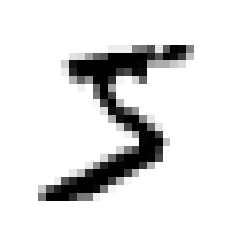

In [9]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

The dataset was already shuffled, so we can jump straight to splitting train and test sets.

In [10]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
y_train_5 = (y_train==5)
y_test_5 = (y_test==5)

In [73]:
sgd_clf = SGDClassifier()
sgd_clf.fit(X_train, y_train_5)
sgd_clf.predict([some_digit])

array([ True])

In [12]:
len(X_test)

10000

## Customized cross validation method

In [13]:
skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))  # prints 0.9502, 0.96565, and 0.96495

0.964
0.9669
0.9501


## Demonstration of how a skewed dataset can affect the performance of a model

In [14]:
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool) 

In [15]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

Even though this Never5Classifier only returns an array of 0s, it still achieved an accuracy of over 90% because the less than 10% of the dataset is images of 5

The metric 'accuracy' only measures how many correct predictions over the total number of instances, which is not optimal in case of skewed dataset such as this one (where we only consider whether an image is a 5 or not). Therefore, other metrics should be introduced as follows: 

In [67]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
confusion_matrix(y_train_5, y_train_pred)

array([[53447,  1132],
       [ 1681,  3740]], dtype=int64)

In [17]:
precision_score(y_train_5, y_train_pred)

0.806074286886928

In [18]:
recall_score(y_train_5, y_train_pred)

0.7245895591219332

In [19]:
f1_score(y_train_5, y_train_pred)

0.7631630075772293

## Experimenting with the decision thresholds

In [20]:
sgd_clf.decision_function([some_digit])

array([4264.45567834])

In [21]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

In [22]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [23]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) 
    plt.xlabel("Threshold", fontsize=16)        
    plt.grid(True)                             
    plt.axis([-50000, 50000, 0, 1]) 

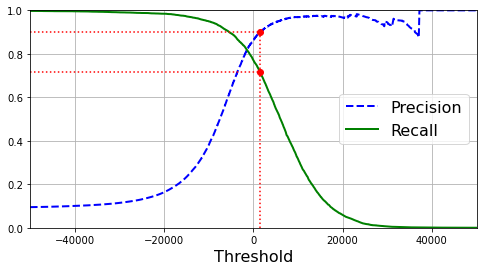

In [24]:
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

plt.figure(figsize=(8, 4))                                                                  
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")                                            
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                                                                        # Not shown
plt.show()

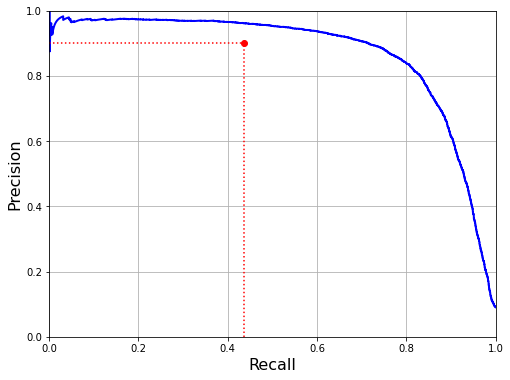

In [25]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([0.4368, 0.4368], [0., 0.9], "r:")
plt.plot([0.0, 0.4368], [0.9, 0.9], "r:")
plt.plot([0.4368], [0.9], "ro")
plt.show()

In [26]:
y_train_pred_90 = y_scores >= threshold_90_precision

In [27]:
precision_score(y_train_5, y_train_pred_90)

0.900092936802974

## ROC Curve

In [28]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

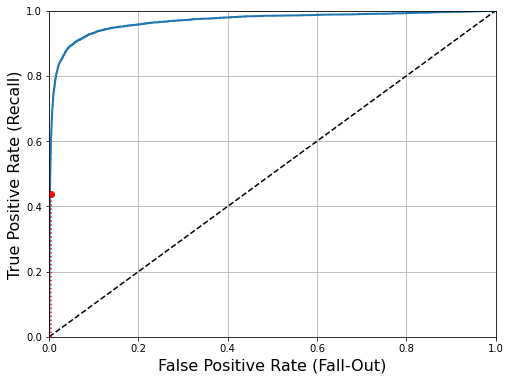

In [29]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.axis([0, 1, 0, 1])                                    
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16)
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)   
    plt.grid(True)                                          

plt.figure(figsize=(8, 6))                        
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") 
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  
plt.plot([4.837e-3], [0.4368], "ro")               
plt.show()

In [30]:
roc_auc_score(y_train_5, y_scores)

0.9682131027141975

In [31]:
forest_clf = RandomForestClassifier(random_state=42)

y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

In [32]:
y_scores_forest =  y_probas_forest[:,1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

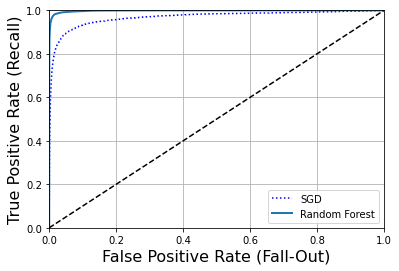

In [33]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [34]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [35]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict')
precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

In [36]:
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591

## Multiclass classification

In [37]:
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([5])

Checking what was happening under the hood: 

In [38]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [39]:
np.argmax(some_digit_scores)

5

In [40]:
svm_clf.classes_[5]

5

## Forcing OvO or OvR strategy

In [41]:
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

array([5])

In [42]:
len(ovr_clf.estimators_)

10

In [43]:
cross_val_score(sgd_clf, X_train, y_train, cv=3)

array([0.86115, 0.8707 , 0.88705])

In [44]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.90125, 0.9011 , 0.90895])

## Error analysis

In [45]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5596,    0,   24,    8,    9,   51,   37,    6,  191,    1],
       [   0, 6412,   38,   27,    5,   44,    4,    8,  191,   13],
       [  27,   28, 5274,   97,   72,   28,   68,   40,  313,   11],
       [  24,   18,  126, 5262,    2,  218,   27,   41,  339,   74],
       [  12,   14,   51,   10, 5223,   11,   36,   26,  283,  176],
       [  29,   16,   33,  177,   55, 4494,   76,   18,  457,   66],
       [  31,   16,   45,    2,   43,   99, 5558,    4,  119,    1],
       [  20,   11,   54,   30,   50,   12,    3, 5715,  150,  220],
       [  18,   61,   45,   95,    3,  130,   26,   11, 5411,   51],
       [  24,   19,   31,   69,  119,   35,    1,  180,  299, 5172]],
      dtype=int64)

Rows are the actual label and columns are what the model predicted

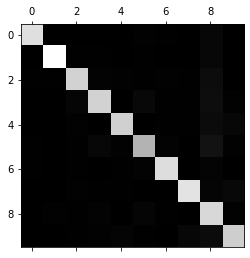

In [46]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

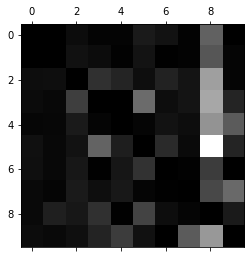

In [47]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [48]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

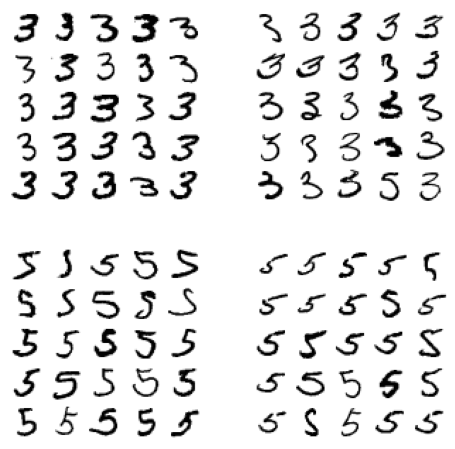

In [49]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

## Multilabel classification

In [50]:
y_train_large = y_train >= 7
y_train_odd = y_train % 2 == 1
y_train_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train_multilabel)
knn_clf.predict([some_digit])

array([[False,  True]])

In [51]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_train_multilabel)
f1_score(y_train_multilabel, y_train_knn_pred, average="macro")

0.977511478985599

## Multioutput classification

In [52]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [53]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

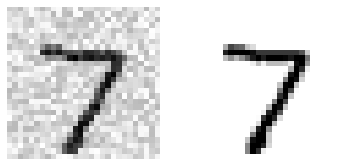

In [54]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

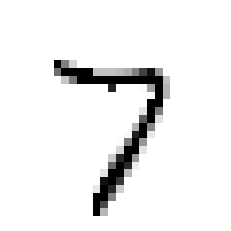

In [55]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

## Exercise -  Experiment with different parameters values

There are 3 classification algorithms mentioned in the beginning of this chapter, which are Stochastic Gradient Descent Classification, Random Forest Classification and Support Vector Classification. All of them were created with the default parameters, so I will attempt to change 5 parameters of them to see how their performance change. First, let's define a helper function to help speed up the process of train and evaluate a bit. In here I use the F1 score as a metric of evaluation.

In [80]:
def train_evaluate_f1_score_multiclass(clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return f1_score(y_test, y_pred, average="macro")

First let's see how the SGD classifier performs with a different number of iterations:

In [83]:
sgd_clf2 = SGDClassifier(max_iter=500)
train_evaluate_f1_score_multiclass(sgd_clf2)

0.8935646554394175

Also random forests with a different number of trees or use the entropy metric to split instead of gini:

In [82]:
rfr2 = RandomForestClassifier(n_estimators=10)
train_evaluate_f1_score_multiclass(rfr2)

0.9470659790612175

In [84]:
rfr3= RandomForestClassifier(criterion='entropy')
train_evaluate_f1_score_multiclass(rfr3)

0.9695670134169301

Last but not least, an SVM classifier with a poly kernel for a better fit using a non-linear model:

In [85]:
svc2 = SVC(kernel='poly')
train_evaluate_f1_score_multiclass(svc2)

0.9770040605295229

Some observations about changing 5 hyperparameters:  
- All of these models perform pretty well in general, with almost all of them achieve above 90% of f1 score. 
- Non-linear models seem to have better performance in this case than the linear ones do.
- Although not shown here, the training time of the SVM classifier was the longest, so there is a performance-training time tradeoff here. 

## Exercise - A classifier with over 97% accuracy

I came across the SVM classifier above by accident and saw that it achieved an F1 score of 97.7%, so I went and evaluate it using the accuracy metrics. The result is demonstrated below:

In [90]:
y_pred = svc2.predict(X_test)
accuracy_score(y_test, y_pred)

0.9771